# Derive cancer and stroma masks in CosMx data



In [1]:
%load_ext autoreload

import os 
import sys
import time
import logging
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from natsort import natsorted

import cv2
import numpy as np
from PIL import Image
import tifffile as tiff
import copy 

sys.path.append(os.path.dirname(os.getcwd()))

from src import get_arrays as ga
from src import contours 
from src import masks
from src.mask_properties import GetMasksProperties

# Cosmx Data

Resolution
1 px = 125 nm = 0.125 um
1 um = 8 px

Transcripts -> 999 + system and negative controls

standard panel (not custom made)

CRC cohort

In [2]:
cosmx_path_s0 =  '../../cosmx_data/S0/S0/20230628_151317_S4/AnalysisResults/iz38iruwno'

folder_names_s0 = [folder_name for folder_name in os.listdir(cosmx_path_s0) if
                os.path.isdir(os.path.join(cosmx_path_s0, folder_name))]

target_files_s0 = [
    os.path.join(cosmx_path_s0, folder, file)
    for folder in os.listdir(cosmx_path_s0)
    if os.path.isdir(os.path.join(cosmx_path_s0, folder))
    for file in os.listdir(os.path.join(cosmx_path_s0, folder))
    if '__target_call_coord.csv' in file
]

target_tum =  ['EPCAM',  'KRT19', 'KRT8', 'KRT18','KRT17','CEACAM6','SPINK1', 'CD24', 'S100A6','RPL37','S100P',]  

files_names = natsorted(target_files_s0)
file_csv = files_names[0]   # 5

df_total = pd.read_csv(file_csv)

df_total['target'].value_counts()
df_total = pd.read_csv(file_csv)
df_total['X'] = (round(df_total['x'])).astype(int)
df_total['Y'] = (round(df_total['y'])).astype(int)
n_genes = len(df_total['target'].unique())
height = max(df_total['X'] + 1)
width = max(df_total['Y'] + 1)

# this makes the sparse df to an array with the spatial information 
target_dict_total = {target: index for index, target in enumerate(df_total['target'].unique())}
array_total = ga.transform_df_to_array(df = df_total, target_dict=target_dict_total, array_shape = (height, width,len(target_dict_total))).astype(np.int8)

# creating subsets 
df_subset_tum, array_subset_tum, target_indices_subset_tum = ga.get_subset_arrays(df_total, array_total,target_dict_total,
                                                                     target_list=target_tum, target_col = 'target')


In [3]:
# param tum
density_th_tum = 40    
min_area_th_tum =  1000 
kernel_size_tum = 80

# param empty
density_th_empty = 140
min_area_th_empty = 2000 
kernel_size_empty = 80

Function 'get_conv_sum' took 0.4729 seconds to execute.
Function 'contours_from_sum' took 30.6679 seconds to execute.
Function 'get_conv_sum' took 8.6737 seconds to execute.
Function 'contours_from_sum' took 14.1242 seconds to execute.


INFO:src.masks:Plot saved at results/kernel/masks_stroma_tumour.png


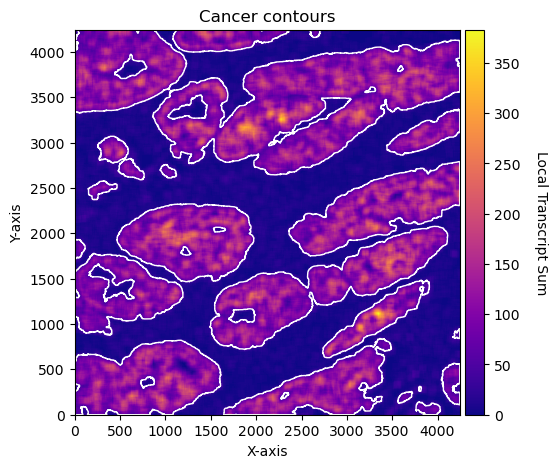

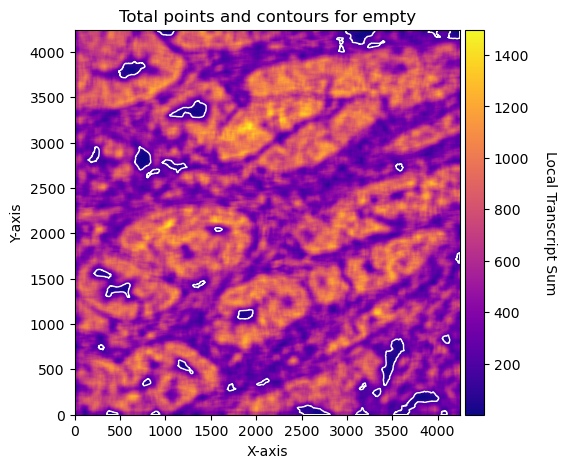

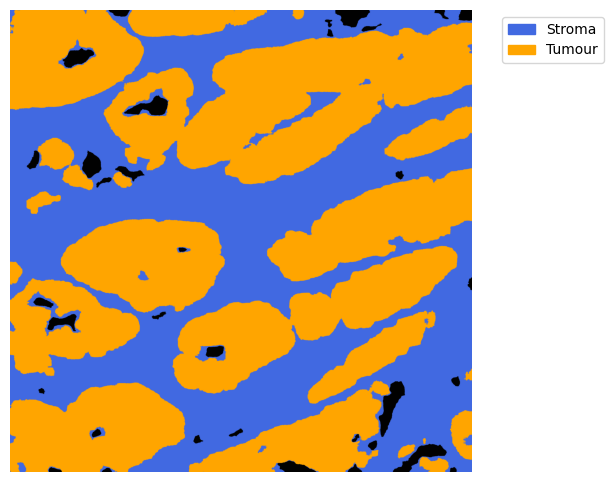

Function 'get_conv_sum' took 0.5047 seconds to execute.
Function 'contours_from_sum' took 18.1128 seconds to execute.
Function 'get_conv_sum' took 8.8974 seconds to execute.
Function 'contours_from_sum' took 9.1963 seconds to execute.


INFO:src.masks:Plot saved at results/kernel/masks_stroma_tumour.png


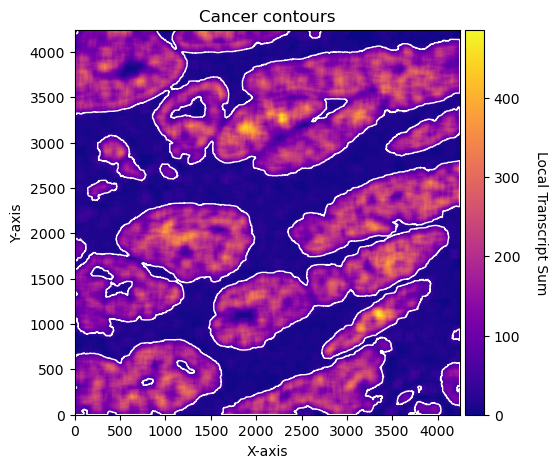

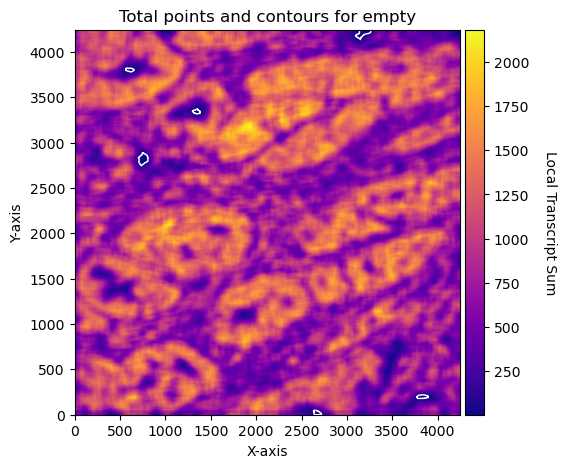

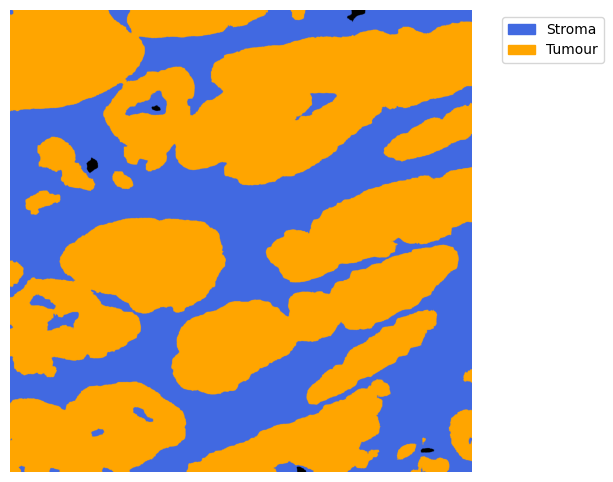

Function 'get_conv_sum' took 0.4969 seconds to execute.
Function 'contours_from_sum' took 100.6717 seconds to execute.
Function 'get_conv_sum' took 8.4585 seconds to execute.
Function 'contours_from_sum' took 11.4421 seconds to execute.


INFO:src.masks:Plot saved at results/kernel/masks_stroma_tumour.png


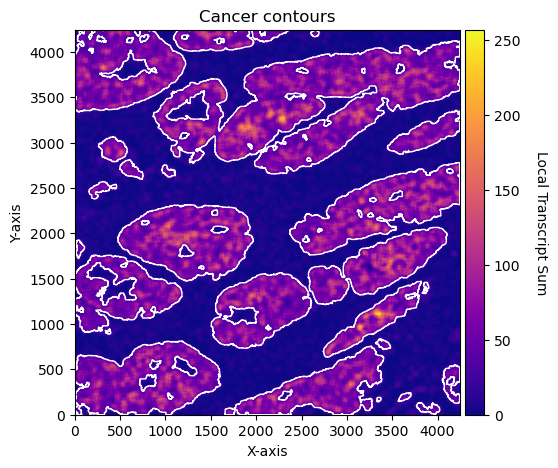

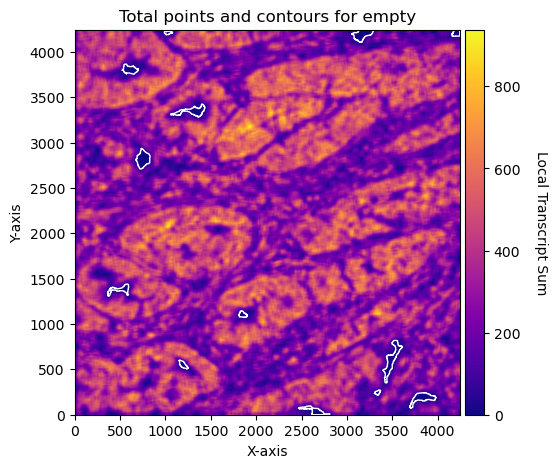

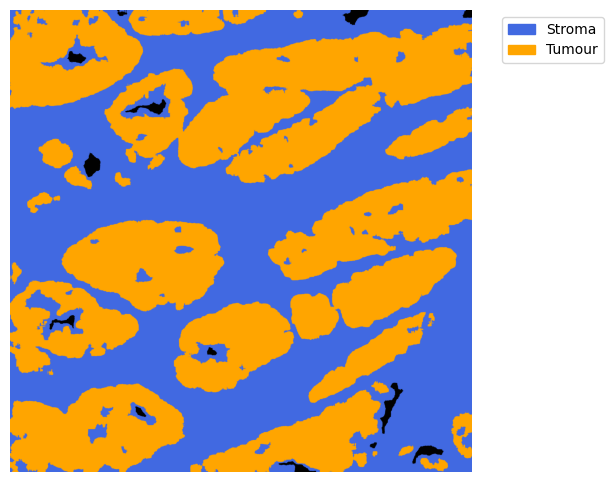

In [4]:
parameters = {
    'i': {'density_th_tum':40, 'kernel_size_tum':80, 'density_th_empty':140, 'kernel_size_empty':80},
    'ii':{'density_th_tum':50, 'kernel_size_tum':100, 'density_th_empty':50, 'kernel_size_empty':100},
    'iii':{'density_th_tum':30, 'kernel_size_tum':60, 'density_th_empty':30, 'kernel_size_empty':60},}

for name, i in parameters.items():
    density_th_tum = i['density_th_tum']
    kernel_size_tum = i['kernel_size_tum']
    density_th_empty = i['density_th_empty']
    kernel_size_empty = i['kernel_size_empty']
    
    # obtain contours 
    CTum = contours.ConvolutionContours(array_subset_tum, contour_name='tum')
    CTum.get_conv_sum(kernel_size=kernel_size_tum, kernel_shape='square')
    CTum.contours_from_sum(density_threshold = density_th_tum,
                           min_area_threshold = min_area_th_tum , directionality = 'higher')
    
    CEmpty = contours.ConvolutionContours(array_total, contour_name='empty')
    CEmpty.get_conv_sum(kernel_size=kernel_size_empty, kernel_shape='square')
    CEmpty.contours_from_sum(density_threshold = density_th_empty,
                           min_area_threshold = min_area_th_empty, directionality = 'lower') # attention that directionality is lower here 
        
    # Cancer contours
    fig1, ax1 = plt.subplots(figsize=(7, 5))
    CTum.plot_conv_sum(cmap='plasma', c_countour='white', ax=ax1)
    ax1.set_title('Cancer contours')
    fig1.savefig(f'results/kernel/cancer_contours{i}.png', dpi=300, bbox_inches='tight')

    # Empty points and contours
    fig2, ax2 = plt.subplots(figsize=(7, 5))
    CEmpty.plot_conv_sum(cmap='plasma', c_countour='white', ax=ax2)
    ax2.set_title('Total points and contours for empty')
    fig2.savefig(f'results/kernel/empty_contours{i}.png', dpi=300, bbox_inches='tight')

    
    #### obtain masks
    GM = masks.GetMasks(image_shape = (height, width))
    
    mask_empty = GM.create_mask(CEmpty.contours)
    mask_tum = GM.create_mask(CTum.contours)
    mask_stroma = GM.subtract_masks(np.ones((height, width), dtype=np.uint8), mask_tum, mask_empty)          
    mask_stroma = GM.filter_mask_by_area(mask_stroma, min_area=700)
    
    # general masks 
    GM.mask_S = mask_stroma
    GM.mask_T = mask_tum
    
    GM.plot_masks(masks=[GM.mask_S, GM.mask_T], mask_names=['Stroma', 'Tumour'],
                  background_color=(1, 1, 1), mask_colors={'Stroma': (65, 105, 225), 'Tumour': (255, 165, 0)},
                  path=f"results/kernel/", show=True, ax=None, figsize=(6, 6))

Xenium

In [5]:
file_csv =  '../../xenium_data/HLA/GD_TMA1_S3/fov_filtered/TMA1_Selection13_filtered.csv'
target_tum = ['EPCAM', 'SMIM22','CLDN3', 'KRT18','LGALS4', 'KRT8', 'ELF3','TSPAN8', 'STMN1', 'CD47', 'MYC', 'LGALS3'] 

df_total = pd.read_csv(file_csv)
df_total = df_total[['x_location', 'y_location', 'feature_name']]
df_total = df_total.rename(columns={'feature_name': 'target'})
df_total = df_total[~df_total['target'].str.contains('System|egative')]
df_total['X'] = df_total['x_location'] - min(df_total['x_location'])
df_total['Y'] = df_total['y_location'] - min(df_total['y_location'])

n_genes = len(df_total['target'].unique())
height = int(max(df_total['X'])) + 1
width = int(max(df_total['Y'])) + 1
target_dict_total = {target: index for index, target in enumerate(df_total['target'].unique())}
array_total = ga.transform_df_to_array(df = df_total, target_dict=target_dict_total, array_shape = (height, width,len(target_dict_total))).astype(np.int8)

# creating subsets 
df_subset_tum, array_subset_tum, target_indices_subset_tum = ga.get_subset_arrays(df_total, array_total,target_dict_total,
                                                                     target_list=target_tum, target_col = 'target')


# param tum
density_th_tum = 20    
min_area_th_tum =  700 
kernel_size_tum = 10   

# param empty
density_th_empty = 30
min_area_th_empty = 400 #400
kernel_size_empty = 10


Function 'get_conv_sum' took 0.0813 seconds to execute.
Function 'contours_from_sum' took 0.6986 seconds to execute.
Function 'get_conv_sum' took 0.6965 seconds to execute.
Function 'contours_from_sum' took 1.2831 seconds to execute.


INFO:src.masks:Plot saved at results/kernel/_i/masks_stroma_cancer.png


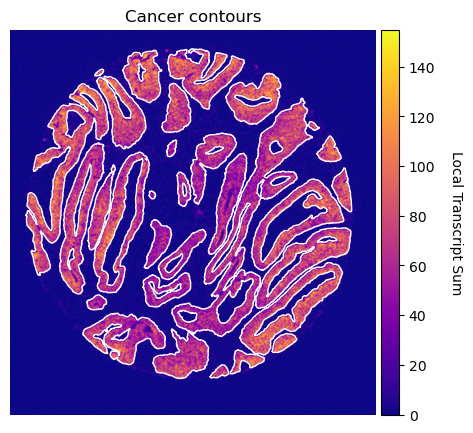

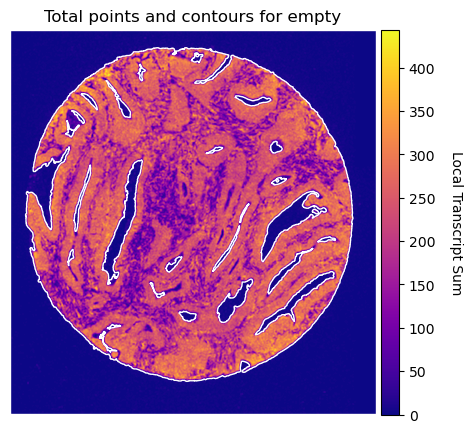

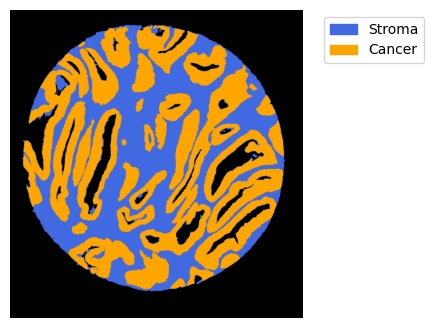

Function 'get_conv_sum' took 0.0789 seconds to execute.
Function 'contours_from_sum' took 1.7601 seconds to execute.
Function 'get_conv_sum' took 0.6857 seconds to execute.
Function 'contours_from_sum' took 1.2888 seconds to execute.


INFO:src.masks:Plot saved at results/kernel/_ii/masks_stroma_cancer.png


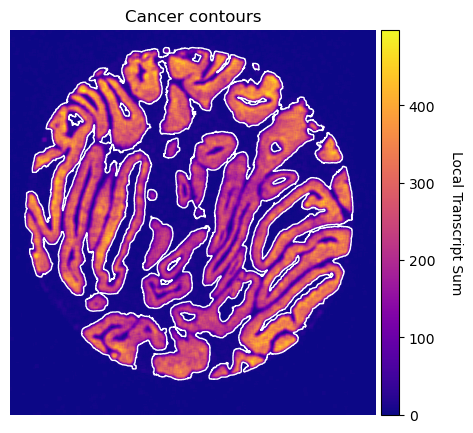

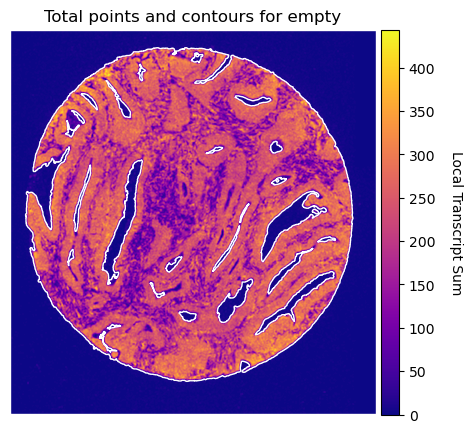

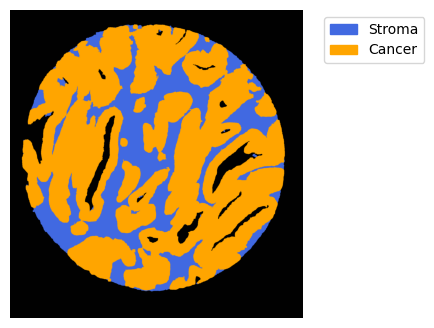

Function 'get_conv_sum' took 0.0855 seconds to execute.
Function 'contours_from_sum' took 4.5325 seconds to execute.
Function 'get_conv_sum' took 0.6752 seconds to execute.
Function 'contours_from_sum' took 1.2888 seconds to execute.


INFO:src.masks:Plot saved at results/kernel/_iii/masks_stroma_cancer.png


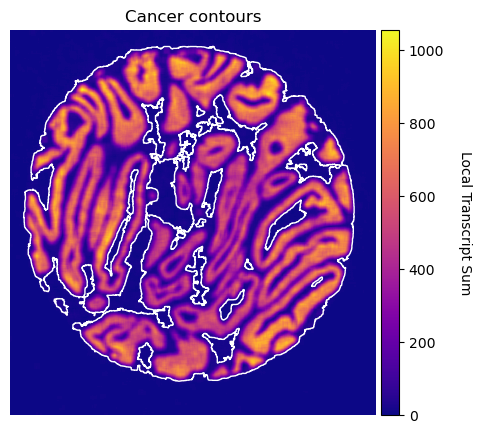

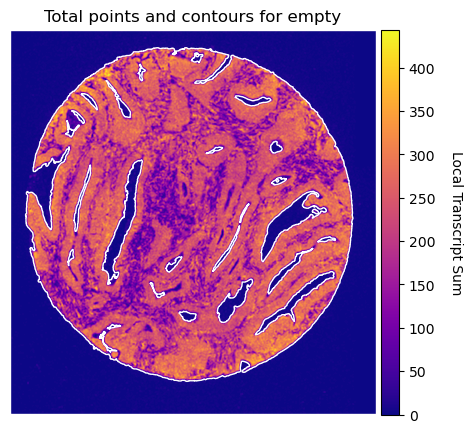

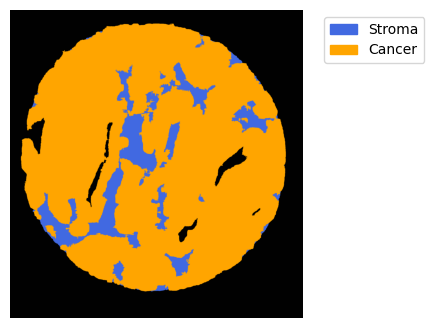

Function 'get_conv_sum' took 0.0771 seconds to execute.
Function 'contours_from_sum' took 12.5930 seconds to execute.
Function 'get_conv_sum' took 0.6947 seconds to execute.
Function 'contours_from_sum' took 1.2833 seconds to execute.


INFO:src.masks:Plot saved at results/kernel/_iv/masks_stroma_cancer.png


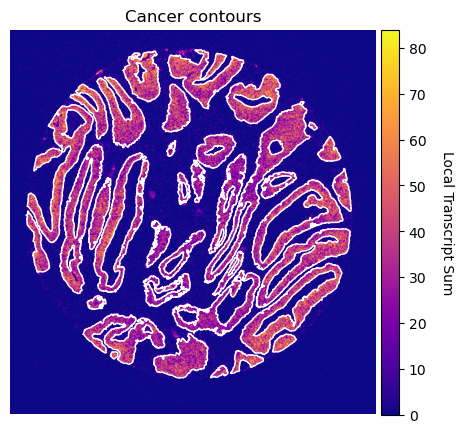

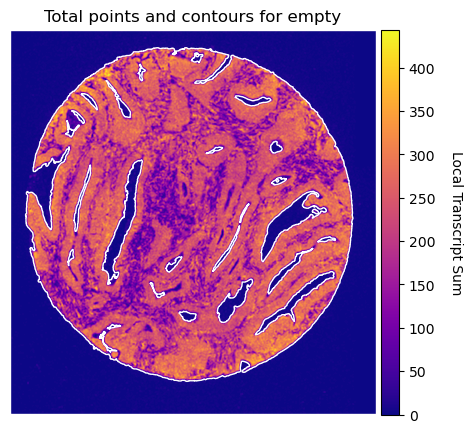

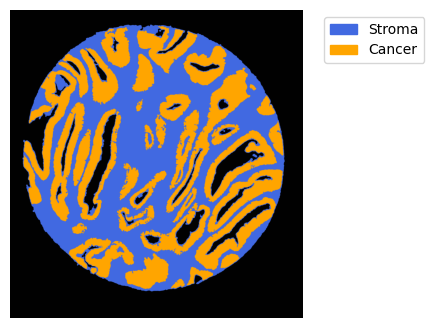

In [6]:
parameters = {
    'i': {'density_th_tum':20, 'kernel_size_tum':10, 'density_th_empty':30, 'kernel_size_empty':10},
    'ii':{'density_th_tum':20, 'kernel_size_tum':20, 'density_th_empty':30, 'kernel_size_empty':10},
    'iii':{'density_th_tum':20, 'kernel_size_tum':30, 'density_th_empty':30, 'kernel_size_empty':10},
    'iv':{'density_th_tum':20, 'kernel_size_tum':7, 'density_th_empty':30, 'kernel_size_empty':10},}

for name, i in parameters.items():
    density_th_tum = i['density_th_tum']
    kernel_size_tum = i['kernel_size_tum']
    density_th_empty = i['density_th_empty']
    kernel_size_empty = i['kernel_size_empty']
    
    
    # obtain contours 
    CTum = contours.ConvolutionContours(array_subset_tum, contour_name='tum')
    CTum.get_conv_sum(kernel_size=kernel_size_tum, kernel_shape='square')
    CTum.contours_from_sum(density_threshold = density_th_tum,
                           min_area_threshold = min_area_th_tum , directionality = 'higher')

    CEmpty = contours.ConvolutionContours(array_total, contour_name='empty')
    CEmpty.get_conv_sum(kernel_size=kernel_size_empty, kernel_shape='square')
    CEmpty.contours_from_sum(density_threshold = density_th_empty,
                           min_area_threshold = min_area_th_empty, directionality = 'lower') # attention that directionality is lower here 

#     fig, axs = plt.subplots(1, 2, figsize=(15, 10))

#     CTum.plot_conv_sum(cmap='plasma', c_countour='white', ax=axs[0])
#     axs[0].set_title('Tum points and tum contours')

#     CEmpty.plot_conv_sum(cmap='plasma', c_countour='white', ax=axs[1])
#     axs[1].set_title('total points and contours for empty')

#     plt.show()
        
    # Cancer contours
    fig1, ax1 = plt.subplots(figsize=(7, 5))
    CTum.plot_conv_sum(cmap='plasma', c_countour='white', ax=ax1)
    ax1.set_title('Cancer contours')
    ax1.axis('off')  # hides both x and y axes, ticks, and frame
    fig1.savefig(f'results/kernel/x_cancer_contours{name}.png', dpi=300, bbox_inches='tight')

    # Empty points and contours
    fig2, ax2 = plt.subplots(figsize=(7, 5))
    CEmpty.plot_conv_sum(cmap='plasma', c_countour='white', ax=ax2)
    ax2.set_title('Total points and contours for empty')
    ax2.axis('off')  # hides both x and y axes, ticks, and frame
    fig2.savefig(f'results/kernel/x_empty_contours{name}.png', dpi=300, bbox_inches='tight')


    #### obtain masks
    GM = masks.GetMasks(image_shape = (height, width))

    mask_empty = GM.create_mask(CEmpty.contours)
    mask_tum = GM.create_mask(CTum.contours)
    mask_stroma = GM.subtract_masks(np.ones((height, width), dtype=np.uint8), mask_tum, mask_empty)          
    mask_stroma = GM.filter_mask_by_area(mask_stroma, min_area=700)

    # general masks 
    GM.mask_S = mask_stroma
    GM.mask_T = mask_tum

    GM.plot_masks(masks=[GM.mask_S, GM.mask_T], mask_names=['Stroma', 'Cancer'],
                  background_color=(1, 1, 1), mask_colors={'Stroma': (65, 105, 225), 'Cancer': (255, 165, 0)},
                  path=f'results/kernel/_{name}', show=True, ax=None, figsize=(6, 4))
